In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from typing import List
from tqdm import tqdm

from nn.NeuralNetwork import NeuralNetwork

### Let's create a small model and see how it is organised.

In [2]:
model = NeuralNetwork(in_features=10, out_features=5, hidden_layers=(10,))
model

[
	Weights(10, 10)
	ReLU
	Weights(10, 5)
	Softmax
]

In [3]:
preds = model.forward(
    np.array([
        [0.1, 1.0, 5.5, -7, 3.3, 1.1, 4, 3.2, 9.9, 0],
        [0.2, -1.2, 11.5, -70, 31.3, 12.1, 7, -1.2, 4.9, 2],
    ])
)

print("Output shape:", preds.shape)
print("Predictions:", preds)

# Sanity check, should sum to 1.0 as last layer is softmax.
print("Prob sums:", np.sum(preds, axis=1))

Output shape: (2, 5)
Predictions: [[9.90992651e-05 5.80324140e-01 3.66340767e-03 9.18072320e-03
  4.06732630e-01]
 [1.88232620e-46 1.00000000e+00 2.77945685e-11 2.72228851e-18
  5.09773389e-18]]
Prob sums: [1. 1.]


In [4]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

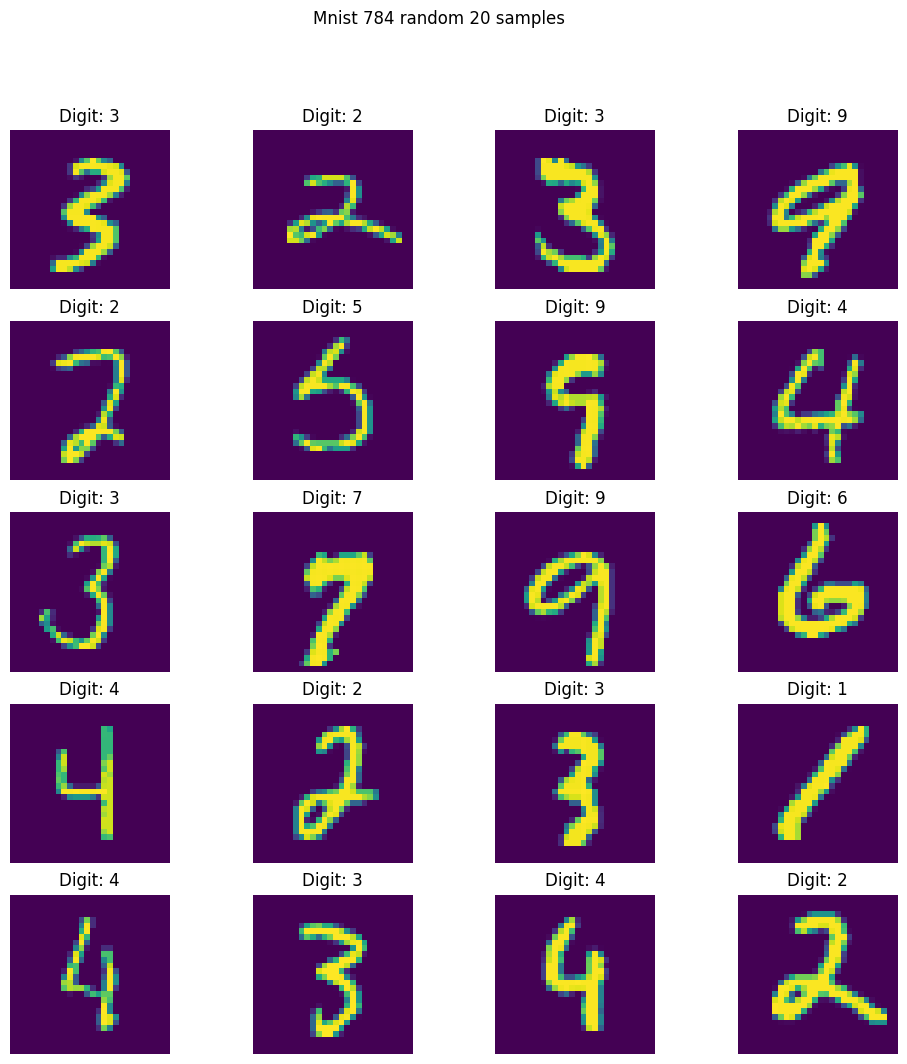

In [5]:
grid_rows = 5
grid_cols = 4

indices = np.random.choice(range(X.shape[0]), grid_rows * grid_cols)

_, axarr = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(12, 12))
for ridx, didx in enumerate(indices):
    gi = ridx // grid_cols
    gj = ridx % grid_cols
    
    axarr[gi, gj].imshow(
        X[didx].reshape(28, 28),
        interpolation="nearest",
    )
    axarr[gi, gj].set_title(f"Digit: {y[didx]}")
    axarr[gi, gj].axis("off")

plt.suptitle(f"Mnist 784 random {grid_rows * grid_cols} samples")
plt.show()

In [6]:
def loss_fn(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    return -np.mean(np.sum(np.multiply(y_true, np.log(y_pred + eps)), axis=1))

In [7]:
def grad_loss_fn(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    batch_size = y_true.shape[0]
    return (-y_true / (y_pred + eps)) / batch_size

In [8]:
def simplified_grad_loss_fn(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    batch_size = y_true.shape[0]
    return (y_pred - y_true) / batch_size

### Utility methods.

MNIST labels are string values of 

In [9]:
def class_to_vector(raw_classes: List[str]) -> np.ndarray:
    y_true = np.zeros((len(raw_classes),10))
    for i, raw_class in enumerate(raw_classes):
        y_true[i, int(raw_class)] = 1
    return y_true

In [10]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, train_size=0.8)

In [11]:
def obtain_accuracy_on(model: NeuralNetwork,
                       X: np.ndarray,
                       y: np.ndarray) -> float:
    y_true = class_to_vector(y)
    y_pred = model.forward(X / 255.0)
    
    accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
    return accuracy / X.shape[0]


def train(model: NeuralNetwork,
          X_train: np.ndarray,
          y_train: np.ndarray,
          X_val: np.ndarray,
          y_val: np.ndarray,
          epochs: int=100,
          batch_size: int=8,
          lr: float=0.1) -> [np.ndarray, np.ndarray, np.ndarray]:    
    train_losses = []
    train_accuracies = []

    val_accuracies = []
    
    for epoch in tqdm(range(epochs)):    
        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]
    
        assert X_train.shape[0] == y_train.shape[0],\
            "Both X and y train should stay the same"
    
        epoch_losses = []
        epoch_accuracy = 0.0
        for idx in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[idx:idx+batch_size, :]
            y_batch = y_train[idx:idx+batch_size]
    
            assert len(X_batch) > 0, \
                "Batch should not be empty"
            
            y_true = class_to_vector(y_batch)
            y_pred = model.forward(X_batch / 255.0)

            loss = loss_fn(y_true, y_pred)
    
            epoch_accuracy += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
            epoch_losses.append(loss)
    
            model.backward(grads=simplified_grad_loss_fn(y_true, y_pred), lr=lr)
    
        train_losses.append(np.mean(epoch_losses))
        train_accuracies.append(epoch_accuracy / X_train.shape[0])

        val_accuracy = obtain_accuracy_on(model, X_val, y_val)
        val_accuracies.append(val_accuracy)

    return train_accuracies, train_losses, val_accuracies

In [12]:
model = NeuralNetwork(in_features=784, out_features=10, hidden_layers=(100,))
train_accuracies, train_losses, val_accuracies = train(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=16, lr=0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]


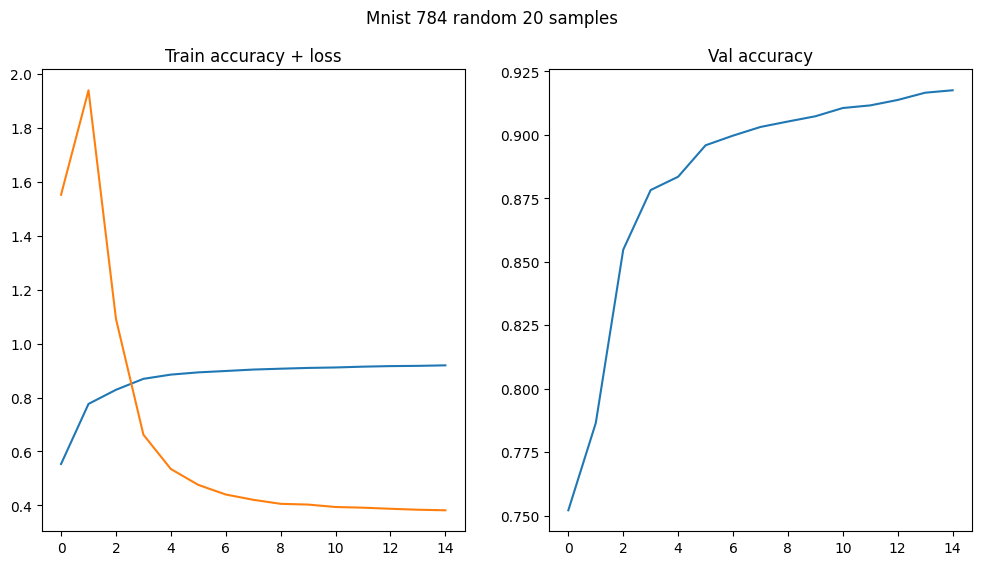

In [13]:
_, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axarr[0].plot(train_accuracies)
axarr[0].plot(train_losses)
axarr[0].set_title("Train accuracy + loss")
axarr[0].ticklabel_format(useOffset=False, style='plain')

axarr[1].plot(val_accuracies)
axarr[1].set_title("Val accuracy")
axarr[1].ticklabel_format(useOffset=False, style='plain')

plt.suptitle(f"Mnist 784 random {grid_rows * grid_cols} samples")
plt.show()

### It is time to give a final run for our network and see whether this is alright.

In [14]:
test_accuracy = obtain_accuracy_on(model, X_test, y_test)

print(f"Test accuracy is {test_accuracy * 100:.2f}%")

Test accuracy is 92.01%


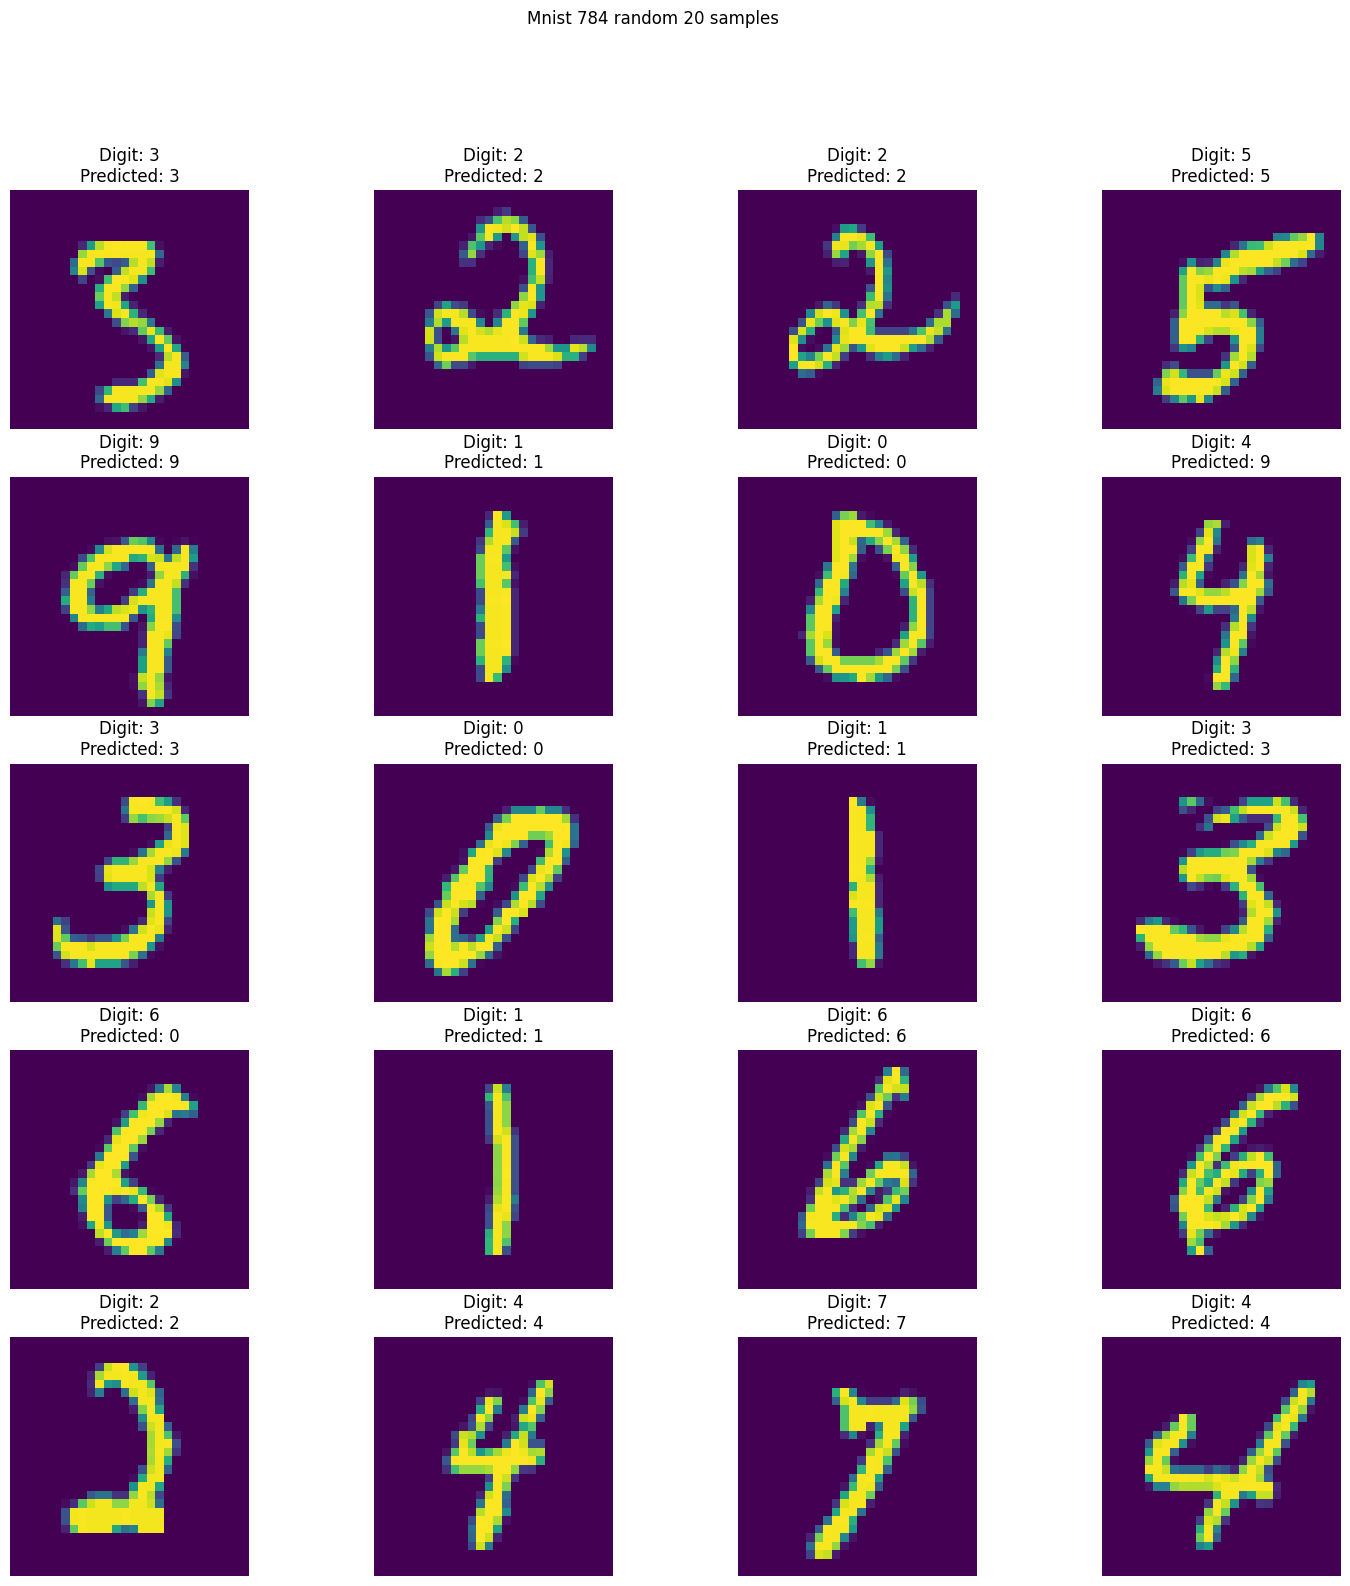

In [15]:
grid_rows = 5
grid_cols = 4

indices = np.random.choice(range(X.shape[0]), grid_rows * grid_cols)
predicted_class = np.argmax(model.forward(X[indices]), axis=1)

_, axarr = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(18, 18))
for ridx, didx in enumerate(indices):
    gi = ridx // grid_cols
    gj = ridx % grid_cols
    
    axarr[gi, gj].imshow(
        X[didx].reshape(28, 28),
        interpolation="nearest",
    )
    axarr[gi, gj].set_title(f"Digit: {y[didx]}\nPredicted: {predicted_class[ridx]}")
    axarr[gi, gj].axis("off")

plt.suptitle(f"Mnist 784 random {grid_rows * grid_cols} samples")
plt.show()